In [2]:
! wget http://pjreddie.com/media/files/cifar.tgz

--2018-07-05 01:33:52--  http://pjreddie.com/media/files/cifar.tgz
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/cifar.tgz [following]
--2018-07-05 01:33:52--  https://pjreddie.com/media/files/cifar.tgz
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168584360 (161M) [application/octet-stream]
Saving to: ‘cifar.tgz’

cifar.tgz           100%[===================>] 160.77M  20.6MB/s    in 8.6s    

2018-07-05 01:34:02 (18.8 MB/s) - ‘cifar.tgz’ saved [168584360/168584360]



In [0]:
!tar -xzf cifar.tgz

In [0]:
from fastai.conv_learner import *
import pandas as pd
import numpy as np
from PIL import Image

In [0]:
labels = !cat cifar/labels.txt

In [0]:
classes = labels

In [0]:
train_list = !ls cifar/train

In [0]:
images = [np.array(Image.open('cifar/train/' + x)) for x in train_list]

In [0]:
R_means = 0
G_means = 0
B_means = 0

for x in images:
  R_means+=np.mean(x[:,:,0])
  G_means+=np.mean(x[:,:,1])
  B_means+=np.mean(x[:,:,2])
  
R_mean = R_means/len(images)
G_mean = G_means/len(images)
B_mean = B_means/len(images)



In [11]:
R_mean/255,G_mean/255,B_mean/255

(0.49139967861519607, 0.48215840839460783, 0.44653091444546567)

In [0]:
stats = (np.array([R_mean/255,G_mean/255,B_mean/255]),np.array([0.24703,0.24349,0.26159]))

In [0]:
images_name = os.listdir('cifar/train')
os.mkdir('cifar/train1')
for x in classes:
  os.mkdir('cifar/train1/' + x)
for x in images_name:
  dir_name = x.split('_')[1][:-4]
  os.renames('cifar/train/'+x,'cifar/train1/'+ dir_name + '/' +x)
  

images_name = os.listdir('cifar/test')
os.mkdir('cifar/test1')
for x in classes:
  os.mkdir('cifar/test1/' + x)
for x in images_name:
  dir_name = x.split('_')[1][:-4]
  os.renames('cifar/test/'+x,'cifar/test1/'+ dir_name + '/' +x)

In [0]:
def get_data(sz,bs):
  tfms = tfms_from_stats(stats,sz,aug_tfms = [RandomFlip()],pad = sz // 8)
  return ImageClassifierData.from_paths('cifar/',trn_name='train1', val_name = 'test1',tfms = tfms,bs = bs)

In [0]:
bs = 256

In [0]:
data = get_data(32,bs)

In [0]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [0]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

In [94]:
learn.lr_find()

 76%|███████▌  | 148/196 [00:20<00:06,  7.17it/s, loss=8.88]

In [0]:
%matplotlib inline

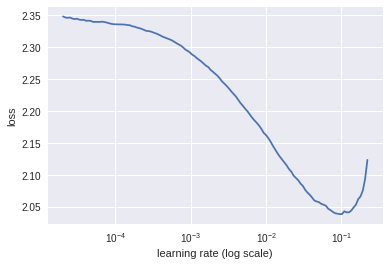

In [100]:
learn.sched.plot()

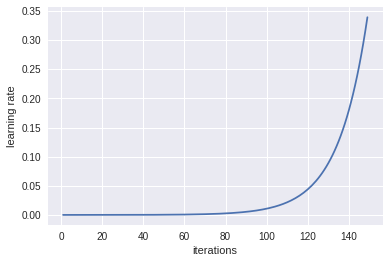

In [102]:
learn.sched.plot_lr()

In [104]:
learn.fit(1e-2, 2, cycle_len=1,cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy   
    0      1.783794   1.690955   0.4073    
    1      1.707114   1.590096   0.4468    
 70%|██████▉   | 137/196 [00:19<00:08,  6.99it/s, loss=1.66]

    2      1.646651   1.557187   0.4568    


[array([1.55719]), 0.4568]

In [0]:
class ConvNet(nn.Module):
    def __init__(self, layers,c):
        super().__init__()
        self.layers = nn.ModuleList([ nn.Conv2d(layers[i], layers[i + 1],kernel_size = 3,stride =2) for i in range(len(layers) - 1) ])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1],c)
    def forward(self, x):
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return F.log_softmax(x, dim=-1)

In [0]:
learn = ConvLearner.from_model_data(ConvNet([3,20,40,80],10), data)

In [156]:
learn.lr_find(end_lr = 100)

 71%|███████   | 139/196 [00:19<00:07,  7.24it/s, loss=7.15e+04]

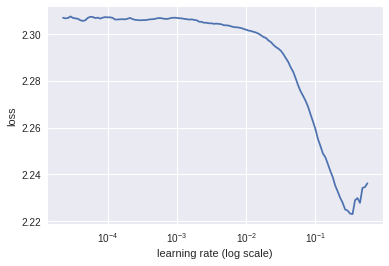

In [157]:
learn.sched.plot()

In [158]:
learn.fit(1e-1, 2, cycle_len=1,cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy   
    0      1.701817   1.599302   0.4222    
    1      1.538725   1.419535   0.493     
 66%|██████▋   | 130/196 [00:17<00:09,  7.23it/s, loss=1.38]

    2      1.330014   1.283045   0.5361    


[array([1.28304]), 0.5361]

In [0]:
class ConvLayer(nn.Module):
  def __init__(self,ni,nf):
    super().__init__()
    self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
    
  def forward(self, x): return F.relu(self.conv(x))
    

class ConvNet(nn.Module):
    def __init__(self, layers,c):
        super().__init__()
        self.layers = nn.ModuleList([ ConvLayer(layers[i], layers[i + 1]) for i in range(len(layers) - 1) ])
        self.out = nn.Linear(layers[-1],c)
    def forward(self, x):
        for l in self.layers:l(x)
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return F.log_softmax(x, dim=-1)

In [160]:
learn.fit(1e-1, 2, cycle_len=1,cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy   
    0      1.330489   1.251512   0.5465    
    1      1.352371   1.264361   0.5444    
 62%|██████▏   | 122/196 [00:18<00:11,  6.72it/s, loss=1.22]

    2      1.199208   1.152387   0.5851    


[array([1.15239]), 0.5851]

In [0]:
class BatchNorm(nn.Module):
  def __init__(self,ni,nf,stride = 2):
    super().__init__()
    self.conv = nn.Conv2d(ni, nf, bias=False,kernel_size=3, stride=2, padding=1)
    self.m = nn.Parameter(torch.ones(nf,1,1))
    self.a = nn.Parameter(torch.zeros(nf,1,1))
    
  def forward(self, x):
    x = F.relu(self.conv(x))
    x_chan = x.transpose(0,1).contiguous().view(x.size(1),-1)
    if self.training:
      self.means = x_chan.mean(1)[:,None,None]
      self.stds = x_chan.std(1)[:,None,None]
    
    return (x - self.means)/self.stds * self.m + self.a
    

class ConvBnNet(nn.Module):
    def __init__(self, layers,c):
        super().__init__()
        self.conv1 =  nn.Conv2d(3,10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([ BatchNorm(layers[i], layers[i + 1]) for i in range(len(layers) - 1) ])
        self.out = nn.Linear(layers[-1],c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return F.log_softmax(x, dim=-1)

In [0]:
learn = ConvLearner.from_model_data(ConvBnNet([10,20, 40, 80, 160], 10), data)

In [188]:
learn.fit(1e-1, 4, cycle_len=1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy   
    0      1.754218   1.635558   0.4167    
    1      1.558866   1.428542   0.4738    
 29%|██▉       | 57/196 [00:09<00:22,  6.21it/s, loss=1.49]

    2      1.417802   1.38899    0.5022    
    3      1.397442   1.301402   0.5267    
 81%|████████  | 158/196 [00:23<00:05,  6.65it/s, loss=1.31]

    4      1.286155   1.192171   0.5687    
    5      1.202853   1.136188   0.595     
    6      1.159363   1.129434   0.5982    
  1%|          | 1/196 [00:01<03:37,  1.12s/it, loss=1.16]

    7      1.227001   1.184879   0.5725    
    8      1.163662   1.113388   0.6037    
 69%|██████▉   | 135/196 [00:20<00:09,  6.45it/s, loss=1.1]

    9      1.094038   1.055741   0.6299    
    10     1.042546   1.031592   0.6426    
 96%|█████████▌| 188/196 [00:29<00:01,  6.42it/s, loss=0.993]

    11     0.993158   0.942613   0.6695    
    12     0.958616   0.953621   0.6671    
    13     0.933894   0.930245   0.6742    
  5%|▌         | 10/196 [00:02<00:45,  4.13it/s, loss=0.927]

    14     0.921293   0.955001   0.6679    


[array([0.955]), 0.6679]

In [0]:
class BatchNorm(nn.Module):
  def __init__(self,ni,nf,stride = 2):
    super().__init__()
    self.conv = nn.Conv2d(ni, nf, bias=False,kernel_size=3, stride=stride, padding=1)
    self.m = nn.Parameter(torch.ones(nf,1,1))
    self.a = nn.Parameter(torch.zeros(nf,1,1))
    
  def forward(self, x):
    x = F.relu(self.conv(x))
    x_chan = x.transpose(0,1).contiguous().view(x.size(1),-1)
    if self.training:
      self.means = x_chan.mean(1)[:,None,None]
      self.stds = x_chan.std(1)[:,None,None]
    
    return (x - self.means)/self.stds * self.m + self.a

In [0]:
class ResnetLayer(BatchNorm):
    def forward(self, x): return x + super().forward(x)

In [0]:
class Resnet(nn.Module):
    def __init__(self, layers,c):
        super().__init__()
        self.conv1 =  nn.Conv2d(3,10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([ BatchNorm(layers[i], layers[i + 1]) for i in range(len(layers) - 1) ])
        self.layers2 = nn.ModuleList([ ResnetLayer(layers[i+1], layers[i + 1],1) for i in range(len(layers) - 1) ])
        self.layers3 = nn.ModuleList([ ResnetLayer(layers[i+1], layers[i + 1],1) for i in range(len(layers) - 1) ])
        self.out = nn.Linear(layers[-1],c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l1,l2,l3 in zip(self.layers,self.layers2,self.layers3): x = l3(l2(l1(x)))
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return F.log_softmax(x, dim=-1)

In [0]:
learn = ConvLearner.from_model_data(Resnet([10,20, 40, 80, 160], 10), data)

In [0]:
wd=1e-5

In [228]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      1.676546   1.541016   0.4444    
    1      1.452369   1.498849   0.4931    
 24%|██▍       | 47/196 [00:14<00:45,  3.30it/s, loss=1.41]

    2      1.285902   1.203158   0.5691    
    3      1.282441   1.282425   0.5655    
 72%|███████▏  | 141/196 [00:32<00:12,  4.32it/s, loss=1.16]

    4      1.124513   1.094326   0.6145    
    5      1.010799   0.985168   0.6516    
 90%|█████████ | 177/196 [00:40<00:04,  4.39it/s, loss=0.953]

    6      0.951026   0.967116   0.6546    


[array([0.96712]), 0.6546]

In [0]:
class Resnet2(nn.Module):
    def __init__(self, layers,c):
        super().__init__()
        self.conv1 =  nn.Conv2d(3,16, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([ BatchNorm(layers[i], layers[i + 1]) for i in range(len(layers) - 1) ])
        self.layers2 = nn.ModuleList([ ResnetLayer(layers[i+1], layers[i + 1],1) for i in range(len(layers) - 1) ])
        self.layers3 = nn.ModuleList([ ResnetLayer(layers[i+1], layers[i + 1],1) for i in range(len(layers) - 1) ])
        self.out = nn.Linear(layers[-1],c)
        self.drop = nn.Dropout(0.2)
        
        
    def forward(self, x):
        x = self.conv1(x)
        for l1,l2,l3 in zip(self.layers,self.layers2,self.layers3): x = l3(l2(l1(x)))
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        x = self.drop(x)
        return F.log_softmax(x, dim=-1)

In [0]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10), data)

In [245]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      1.956423   1.691327   0.4033    
    1      1.758994   1.452216   0.472     
 24%|██▍       | 47/196 [00:15<00:48,  3.08it/s, loss=1.68]

    2      1.557765   1.33557    0.5248    
    3      1.646108   1.374427   0.5021    
 72%|███████▏  | 141/196 [00:39<00:15,  3.58it/s, loss=1.5]

    4      1.479556   1.17899    0.5872    
    5      1.340265   1.072884   0.6268    
 91%|█████████ | 178/196 [00:49<00:05,  3.59it/s, loss=1.28]

    6      1.28255    1.072367   0.6291    


[array([1.07237]), 0.6291]